# ModelEvaluation

## model ver1

    import model as MODEL
    MODEL_PATH = os.path.abspath('../notebook/train_log_20181025/model/model.ckpt')
    
    total_parameters: 3480049
    batch size: 250
    total data number: 250
    total inference time: 2.15691900253
    inference time per object: 0.00862767601013
    
## model ver2

    import model_64_128_mp_256_128_5 as MODEL
    MODEL_PATH = os.path.abspath('../notebook/train_log_20181031_model_64_128_mp_256_128_5/model/model.ckpt')
    
    total_parameters: 3100238
    batch size: 250
    total data number: 250
    total inference time: 2.4681789875
    inference time per object: 0.00987271595001
    
## model opt1

    import model_opt1 as MODEL
    MODEL_PATH = os.path.abspath('../notebook/train_log_20181101_opt01/model/model.ckpt')

    total_parameters: 2811086
    batch size: 250
    total data number: 250
    total inference time: 1.87801408768
    inference time per object: 0.00751205635071
    
## model opt5
    total_parameters: 354606
    batch size: 250
    total data number: 250
    total inference time: 0.525923013687
    inference time per object: 0.00210369205475

In [1]:
import os, sys

import time

sys.path.append( os.path.abspath('../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../Network/model') )
from train import *

# import model as MODEL
# import model_64_128_mp_256_128_5 as MODEL
# import model_opt1 as MODEL
import model_opt5 as MODEL

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
""" Parameters """

data_test_path = []


dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)

dtp = os.path.join( \
          os.path.abspath('../../Dataset/dataset/db_aug_v4_v_500_20181031_ndb_aug_v2_20181020'), 'test.h5' \
                  )
data_test_path.append(dtp)


data_name_list = ['original', '0.1', '0.2', '0.3', '0.4', '0.5']


MODEL_PATH = os.path.abspath('../notebook/train_log_20181101_opt05/model/model.ckpt')


""" Parameters """
GPU_INDEX = 0
NUM_POINT = 256
NUM_CLASSES = 5
BATCH_SIZE = 500

Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_20181031_ndb_aug_v2_20181020/test.h5
Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_v_100_20181031_ndb_aug_v2_20181020/test.h5
Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_v_200_20181031_ndb_aug_v2_20181020/test.h5
Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_v_300_20181031_ndb_aug_v2_20181020/test.h5
Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_v_400_20181031_ndb_aug_v2_20181020/test.h5
Load data: /media/kyungpyo/SmartCarContest/MasterThesisProject/Dataset/dataset/db_aug_v4_v_500_20181031_ndb_aug_v2_20181020/test.h5


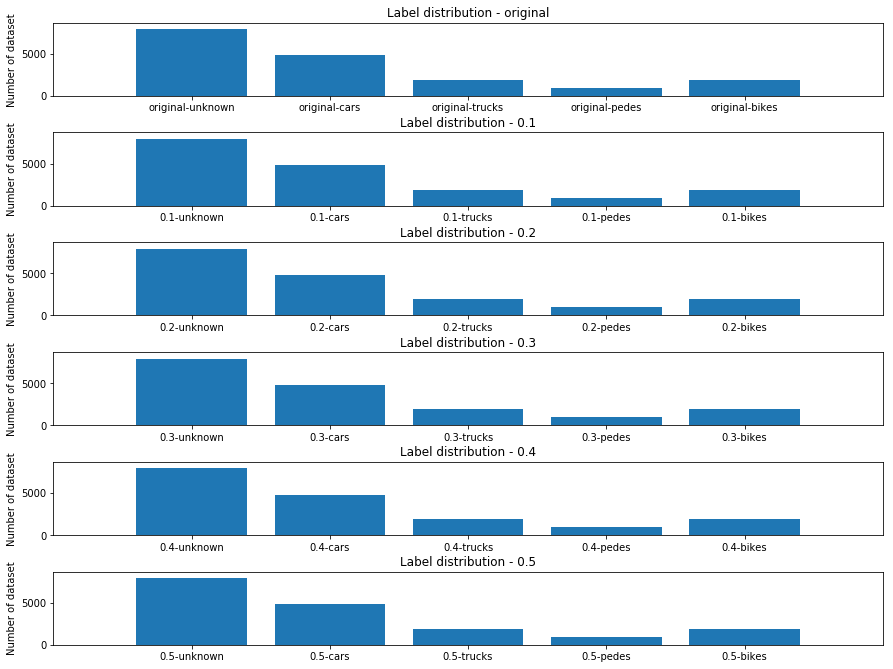

In [3]:
""" Load dataset """
data = []
label = []

for dtp in data_test_path:
    d, l = load_h5(dtp)
    
    data.append(d)
    label.append(l)
    
    print "Load data: {}".format(dtp)
    

""" Data statistics"""
label_list = [0,1,2,3,4]

plt.close('all')
fig = plt.figure( figsize=(12,9) )
fig.subplots_adjust(left=0.02,top= 0.98,bottom=0.02,right=0.98,wspace=0.1,hspace=0.5)


for i in range( len(data) ):
    y_val = []
    x_name = []

    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

    x_name.append("{}-unknown".format(data_name_list[i]))
    x_name.append("{}-cars".format(data_name_list[i]))
    x_name.append("{}-trucks".format(data_name_list[i]))
    x_name.append("{}-pedes".format(data_name_list[i]))
    x_name.append("{}-bikes".format(data_name_list[i]))

    index = range( len(x_name) )
    
    ax=fig.add_subplot(len(data),1,i+1)

    ax.bar(index, y_val, tick_label=x_name, align='center')
    ax.set_ylabel('Number of dataset')
    ax.set_title('Label distribution - {}'.format(data_name_list[i]))
    ax.set_xlim( -1, len(x_name))
    ax.set_ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
is_training = False

# reset graph
tf.reset_default_graph()

with tf.device('/gpu:'+str(GPU_INDEX)):
    pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
    is_training_pl = tf.placeholder(tf.bool, shape=())

    # simple model
    pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl)
    loss = MODEL.get_loss(pred, labels_pl, end_points)

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = True

ops = {'pointclouds_pl': pointclouds_pl,
       'labels_pl': labels_pl,
       'is_training_pl': is_training_pl,
       'pred': pred,
       'loss': loss}

# ops.reset_default_graph() 

sess = tf.Session(config=config)

# Restore variables from disk.
saver.restore(sess, MODEL_PATH)

print "Model restored"
sys.stdout.flush()


""" Number of parameters """
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
#     print "(shape)", (shape)
#     print "(len(shape))", (len(shape))
    variable_parameters = 1
    for dim in shape:
#         print "(dim)", (dim)
        variable_parameters *= dim.value
#         print "(variable_parameters)", (variable_parameters)
    total_parameters += variable_parameters
    

results_list = []
com_time = 0
num_total_sample = 0
total_label = []
total_label_pred = []

for i in range(len(data)):
    
    print "Dataset {} / {} ".format(i+1, len(data))
    sys.stdout.flush()
    
    ## Evaluation using test set    
    is_training = False
    total_correct = 0
    total_seen = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    total_detect_class = [0 for _ in range(NUM_CLASSES)]
    total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

    current_data = data[i]
    current_label = label[i]

    num_batches = current_data.shape[0] // BATCH_SIZE
    
    print "Number of total dataset / evaluated dataset: {} / {}".format(current_data.shape[0], num_batches * BATCH_SIZE)
    sys.stdout.flush()
    sys.stdout.flush()
    
    results = []

    for batch_idx in trange(num_batches):
    
        start_idx = batch_idx * BATCH_SIZE
        end_idx = (batch_idx+1) * BATCH_SIZE

        feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx],
                     ops['labels_pl']: current_label[start_idx:end_idx],
                     ops['is_training_pl']: is_training}
        
        start_t = time.time()
        loss_val, pred_val = sess.run([ops['loss'], ops['pred']],
                                  feed_dict=feed_dict)
        com_time += time.time() - start_t
        num_total_sample += BATCH_SIZE

        pred_val = np.argmax(pred_val, 1)
        results.extend(pred_val)
    
    results_list.append(results)
    
print "total_parameters:", (total_parameters)
print "batch size:" , BATCH_SIZE
print "total data number:" , num_total_sample
print "total inference time:" , com_time
print "inference time per object:" , float(com_time) / float(num_total_sample)

INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
INFO:tensorflow:Restoring parameters from /media/kyungpyo/SmartCarContest/MasterThesisProject/Network/notebook/train_log_20181101_opt05/model/model.ckpt
Model restored
Dataset 1 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000


100%|██████████| 34/34 [00:29<00:00,  1.14it/s]

Dataset 2 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000



100%|██████████| 34/34 [00:33<00:00,  1.02it/s]

Dataset 3 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000



100%|██████████| 34/34 [00:29<00:00,  1.14it/s]

Dataset 4 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000



100%|██████████| 34/34 [00:28<00:00,  1.21it/s]

Dataset 5 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000



100%|██████████| 34/34 [00:28<00:00,  1.20it/s]

Dataset 6 / 6 
Number of total dataset / evaluated dataset: 17496 / 17000



100%|██████████| 34/34 [00:28<00:00,  1.19it/s]

total_parameters: 354606
batch size: 500
total data number: 102000
total inference time: 177.439560175
inference time per object: 0.00173960353113


In [15]:
""" Accuracy graph """

incorrect_idx_list = []
all_accuracy_list = []
cls_recall_list = []
cls_precision_list = []

for i, results in enumerate(results_list):

    print "Evaluation results - {}".format(data_name_list[i])
    
    prediction = np.array(results)
    ground_truth = np.array(label[i][:prediction.shape[0]])
    correct = np.sum( prediction == ground_truth )

    ## calculate accuracy
    all_accuracy = float( correct ) / float( prediction.shape[0] )
    cls_recall = []
    cls_precision = []
    
    for j in range(NUM_CLASSES):
        tp = np.sum(  ( prediction == ground_truth ) * ( prediction == j * np.ones(prediction.shape) )  )
        tn = np.sum(  ( prediction == ground_truth ) * ( prediction != j * np.ones(prediction.shape) )  )
        fp = np.sum(  ( prediction != ground_truth ) * ( prediction == j * np.ones(prediction.shape) )  )
        fn = np.sum(  ( prediction != ground_truth ) * ( prediction != j * np.ones(prediction.shape) )  )
        
        p = float(tp) / float( tp + fp )
        r = float(tp) / float( tp + fn )
        
        cls_precision.append(p)
        cls_recall.append(r)
    all_accuracy_list.append(all_accuracy)
    cls_recall_list.append(cls_recall)
    cls_precision_list.append(cls_precision)

    ## find incorrect idx
    
    incorrect_idx = []
    
    for j, gt in enumerate(ground_truth):

        pred = prediction[j]
        if not gt == pred: incorrect_idx.append(j)
                          
            #print "gt: {}, pred: {}".format(gt, pred)

    print "Correct / incorrect : {} / {} - {}% \n".format( 
        ground_truth.shape[0] - len(incorrect_idx) , 
        len(incorrect_idx),
        all_accuracy * 100. )
    
    incorrect_idx_list.append(incorrect_idx)
        
        
""" Confusion matrix """

prediction = np.array(results_list[-1])
ground_truth = np.array(label[-1][:prediction.shape[0]])

cm = confusion_matrix(ground_truth, prediction)
label_list = ['unknown', 'car', 'truck', 'pedes', 'bikes']
def plot_confusion_matrix(cm, normalize = True, title='Confusion matrix', cmap=plt.cm.Oranges, label_list = None):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ax = plt.gca()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks, rotation=45)
        
    if label_list == None:
        ax.set_xticklabels((ax.get_xticks()).astype(str))
    else:
        ax.set_xticklabels(label_list)
        ax.set_yticklabels(label_list)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
prediction = np.array(results)
ground_truth = np.array(label[i][:prediction.shape[0]])
target_names = ['unknown', 'car', 'truck', 'pedes', 'bike']
print(classification_report(ground_truth, prediction, target_names=target_names))


""" Visualization - """
plt.close('all')
%matplotlib qt

fig = plt.figure(1)
ax = fig.add_subplot(111)

x = range( len(data_name_list) - 1 )
ac = ax.plot(x, np.array(all_accuracy_list[1:]), marker = 'o', label = 'accuracy')#, color = 1, marker = 'o', label = data_name_list[0])

for i in range( len(data_name_list) - 1 ):
    ax.annotate("{:.2f}%".format(np.array(all_accuracy_list[i+1])*100.), 
                (x[i] + 0.05 , all_accuracy_list[i+1]) ,  fontsize=10, fontweight='bold')

"""color = ac[0].get_color(),"""

cr = []
for i in range(1,NUM_CLASSES):
    cr = ax.plot(x, np.array(cls_recall_list)[1:, i], linestyle = '--', label = 'recall-{}'.format(label_list[i]), marker = '^')
    cp = ax.plot(x, np.array(cls_precision_list)[1:, i], linestyle = '--', label = 'precision-{}'.format(label_list[i]), marker = 's')

ax.set_xticks(x)
xticlabels = ['0.1', '0.2', '0.3', '0.4', '0.5']
ax.set_xticklabels(xticlabels)

ax.set_xlabel('Dataset(voxel size [m])')
ax.set_ylabel('Accuracy (recall, precision)')

ax.set_title('Analysis on voxel size')
plt.grid()
plt.legend()
plt.show()

""" Visualization """
fig = plt.figure(2)
ax = fig.add_subplot(111)

np.set_printoptions(precision=1) 
# print('Confusion matrix, without normalization')
# print(cm)
fig, ax = plt.subplots()
plot_confusion_matrix(cm, normalize = True,  title='Confusion matrix with normalization', label_list=label_list)

plt.show()

Evaluation results - original
Correct / incorrect : 16886 / 114 - 99.3294117647% 

Evaluation results - 0.1
Correct / incorrect : 16931 / 69 - 99.5941176471% 

Evaluation results - 0.2
Correct / incorrect : 16949 / 51 - 99.7% 

Evaluation results - 0.3
Correct / incorrect : 16919 / 81 - 99.5235294118% 

Evaluation results - 0.4
Correct / incorrect : 16835 / 165 - 99.0294117647% 

Evaluation results - 0.5
Correct / incorrect : 16797 / 203 - 98.8058823529% 

             precision    recall  f1-score   support

    unknown       0.98      0.99      0.99      7896
        car       1.00      1.00      1.00      4800
      truck       0.98      1.00      0.99      1920
      pedes       0.99      0.86      0.92       960
       bike       1.00      0.99      0.99      1424

avg / total       0.99      0.99      0.99     17000

Normalized confusion matrix


Confusion matrix, without normalization
[[7840    4   42    5    5]
 [   0 4800    0    0    0]
 [   0    0 1920    0    0]
 [ 132    0    0  828    0]
 [  15    0    0    0 1409]]
Normalized confusion matrix
